## 6. Long Short Term Memory (LSTM) Neural Network

Long Short-Term Memory (LSTM) networks are a type of recurrent neural network capable of learning order dependence in sequence prediction problems. LSTM networks are composed of nodes or LSTM units. A common LSTM unit is composed of a cell, an input gate, an output gate and a forget gate. The cell remembers values over arbitrary time intervals and the three gates regulate the flow of information into and out of the cell.

LSTMs were developed to deal with the vanishing gradient problem that can be encountered when training traditional RNNs. Relative insensitivity to gap length is an advantage of LSTM over RNNs, hidden Markov models and other sequence learning methods in numerous applications. As such, LSTM networks are well-suited to classifying, processing and making predictions based on time series data, since there can be lags of unknown duration between important events in a time series.

In [4]:
# Import essential libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
from functools import reduce
from pandas import read_csv
from matplotlib import pyplot

# Import LSTM libraries
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.metrics import mean_squared_error
import tensorflow as tf 

### Predicting CPI using lagged CPI data

In [6]:
cpi_df = pd.read_csv("data/cleaned/cleaned_cpi.csv")

# Set date column as index
#cpi_df.set_index('Date', inplace = True)

# Remove change columns as we will be using the absolute index value for this
cpi_df.drop(columns = ['Value', 'ChangePercentYear'], axis = 1, inplace = True)
cpi_df.dropna(inplace = True)
len(cpi_df)

930

In [8]:
cpi_train = cpi_df.iloc[:800]
cpi_test = cpi_df.iloc[130:]

# Pre-process data using a minmaxscaler to convert all data attributes to a range of 0-1
# Instantiate scaler object
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler.fit(cpi_train.set_index('Date'))
scaled_cpi_train = scaler.transform(cpi_train.set_index('Date'))
scaled_cpi_test = scaler.transform(cpi_test.set_index('Date'))

In [10]:
# define generator
n_input = 12  # We will use the last 12 months of CPI data to predict the next month
n_features = 1
generator = TimeseriesGenerator(scaled_cpi_train, scaled_cpi_train, length=n_input, batch_size=1)

In [12]:
# define our LSTM model
model = Sequential()
# LSTM with 100 nodes
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')   # loss function assigned to mean square error
model.summary()

# fit the model
model.fit(generator, epochs = 5)

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 100)            │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,901 (159.77 KB)

 Trainable params: 40,901 (159.77 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5


/opt/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


788/788 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0231
Epoch 2/5
788/788 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0224
Epoch 3/5
788/788 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0208
Epoch 4/5
788/788 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0214
Epoch 5/5
788/788 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0188


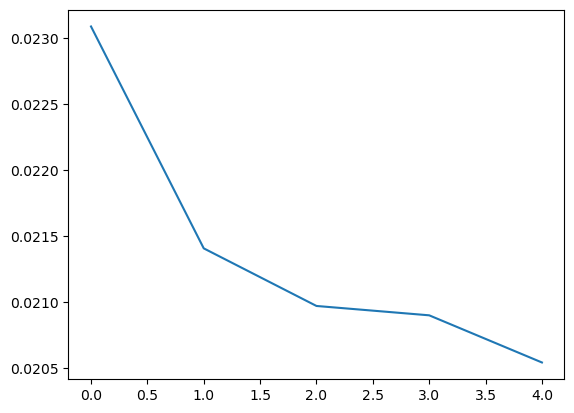

In [14]:
# plot the loss per epoch
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [16]:
# Use the trained model to generate and store our test predictions
test_predictions = []

first_eval_batch = scaled_cpi_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))
n=0

for i in range(len(scaled_cpi_test)):
    
    # get the prediction value for the first batch
    current_pred = model.predict(current_batch)[0]
    
    # append the prediction into the array
    test_predictions.append(current_pred) 
    
    # remove the first value and update the batch with the next value from the test set
    current_batch = np.append(current_batch[:,1:,:],scaled_cpi_test[n:n+1].reshape((1, 1, n_features)),axis=1)
    n += 1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


In [18]:
# Convert our predictions back to their pre scaled forms
true_predictions = scaler.inverse_transform(test_predictions)

# Apend the predictions back to the test data set
cpi_test['Predictions'] = true_predictions

/var/folders/mq/2hlc7t3j1n70sc6bwnvg849r0000gn/T/ipykernel_94523/3862874477.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cpi_test['Predictions'] = true_predictions


Test RMSE: 0.002361979406184123


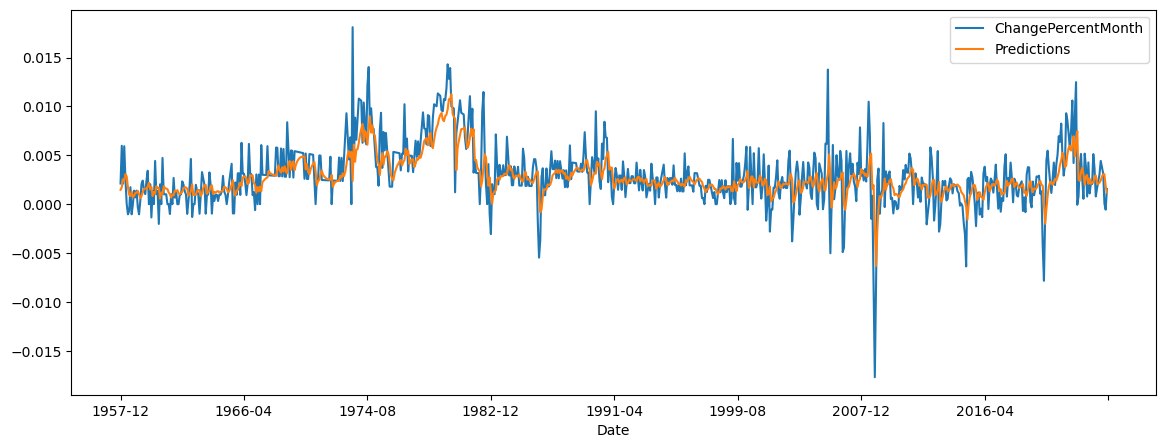

In [20]:
cpi_test.set_index('Date', inplace = True)
cpi_test.plot(figsize=(14,5))
uni_rmse=sqrt(mean_squared_error(cpi_test['ChangePercentMonth'],cpi_test['Predictions']))
print('Test RMSE:' , uni_rmse)

### Multivariate Forecasting of CPI with LTSMD

#### Data Preparation
For this section, we will aim to create a Long Short Term Memory model which accepts inputs from a variety of predictors to forecast CPI.

We will use the 4 highest correlated variables based on monthly percentage change that we found in the Data Visualisation part of this project: LaggedCPI, PPI, unemployment rates, and oil prices.

In [22]:
# Import all datasets
oil_data_clean = pd.read_csv('data/cleaned/cleaned_oil.csv')
ppi_data_clean = pd.read_csv('data/cleaned/cleaned_ppi.csv')
unemp_data_clean = pd.read_csv('data/cleaned/cleaned_unemp.csv')
lcpi_data_clean = pd.read_csv('data/cleaned/cleaned_lagged_cpi.csv')
cpi_data_clean = pd.read_csv('data/cleaned/cleaned_cpi.csv')

In [24]:
oil_data_clean.drop(columns = ['ChangePercentYear', 'Value'], axis = 1, inplace = True)
ppi_data_clean.drop(columns = ['ChangePercentYear', 'Value'], axis = 1, inplace = True)
unemp_data_clean.drop(columns = ['ChangePercentYear', 'Value'], axis = 1, inplace = True)
lcpi_data_clean.drop(columns = ['ChangePercentYear', 'Value'], axis = 1, inplace = True)
cpi_data_clean.drop(columns = ['ChangePercentYear', 'Value'], axis = 1, inplace = True)

In [26]:
oil_data_clean.columns = ['Date','Oil']
oil_data_clean.dropna(inplace = True)
ppi_data_clean.columns = ['Date','PPI']
ppi_data_clean.dropna(inplace = True)
unemp_data_clean.columns = ['Date','Unemployment']
unemp_data_clean.dropna(inplace = True)
lcpi_data_clean.columns = ['Date','LaggedCPI']
lcpi_data_clean.dropna(inplace = True)
cpi_data_clean.columns = ['Date','CPI']
cpi_data_clean.dropna(inplace = True)

dataframe_list = [cpi_data_clean, oil_data_clean, ppi_data_clean, unemp_data_clean, lcpi_data_clean]
# Join all datasets together
df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['Date'], how='inner'), dataframe_list)
df_merged.set_index('Date', inplace = True)

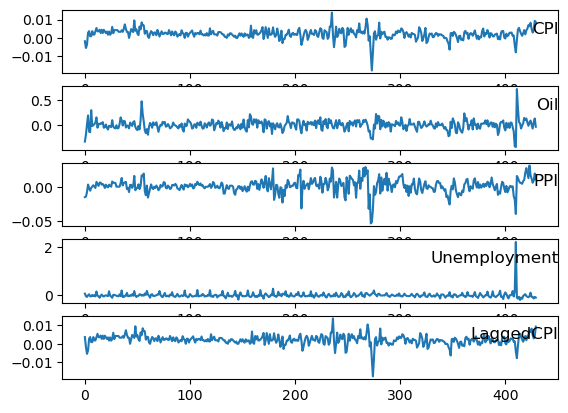

In [28]:
values = df_merged.values
# specify columns to plot
groups = [0, 1, 2, 3, 4]
i = 1
# plot each column
pyplot.figure()
for group in groups:
	pyplot.subplot(len(groups), 1, i)
	pyplot.plot(values[:, group])
	pyplot.title(df_merged.columns[group], y=0.5, loc='right')
	i += 1
pyplot.show()

#### Data Preparation for LSTM Model

We will be using the last month of data to predict CPI

In [30]:
df_merged

,CPI,Oil,PPI,Unemployment,LaggedCPI
Date,,,,,
1986-02,-0.001820,-0.325774,-0.014535,0.068493,0.003653
1986-03,-0.005469,-0.184347,-0.013766,-0.038462,-0.001820
1986-04,-0.003666,0.018239,-0.006979,-0.066667,-0.005469
1986-05,0.002760,0.197819,0.004016,0.000000,-0.003666
1986-06,0.003670,-0.126788,-0.001000,0.042857,0.002760
...,...,...,...,...,...
2021-07,0.004914,0.015551,0.012888,-0.065574,0.008240
2021-08,0.002923,-0.065664,0.006750,-0.070175,0.004914
2021-09,0.004025,0.057877,0.009695,-0.132075,0.002923


In [32]:
# Splitting the dataset into train and test sets
df_train = df_merged.iloc[:340]
df_test = df_merged.iloc[340:]

In [34]:
# Use MinMaxScaler to normalise are values by scaling down values between a range of -1 to 1
# Instantiate scaler objects
x_scaler = MinMaxScaler(feature_range=(-1, 1))
y_scaler = MinMaxScaler(feature_range=(-1, 1))

x_train = x_scaler.fit_transform(df_train[['Oil','PPI','Unemployment','LaggedCPI']])
y_train = y_scaler.fit_transform(df_train[['CPI']])

x_test = x_scaler.transform(df_test[['Oil','PPI','Unemployment','LaggedCPI']])
y_test = y_scaler.transform(df_test[['CPI']])

In [36]:
# reshape input to be 3D [samples, timesteps, features]
x_train = x_train.reshape((x_train.shape[0], 1, x_train.shape[1]))
x_test = x_test.reshape((x_test.shape[0], 1, x_test.shape[1]))
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(340, 1, 4) (340, 1) (90, 1, 4) (90, 1)


We will define the LSTM with 100 neurons in the first hidden layer and 1 neuron in the output layer for predicting pollution. The input shape will be 1 time step with 4 features.

We will use the Mean Squared Error (MSE) loss function and the efficient Adam version of stochastic gradient descent.

The model will be fit for 30 training epochs.

Epoch 1/30


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


340/340 - 1s - 2ms/step - loss: 0.0205 - val_loss: 0.0113
Epoch 2/30
340/340 - 0s - 483us/step - loss: 0.0115 - val_loss: 0.0109
Epoch 3/30
340/340 - 0s - 472us/step - loss: 0.0113 - val_loss: 0.0102
Epoch 4/30
340/340 - 0s - 474us/step - loss: 0.0111 - val_loss: 0.0099
Epoch 5/30
340/340 - 0s - 474us/step - loss: 0.0111 - val_loss: 0.0097
Epoch 6/30
340/340 - 0s - 472us/step - loss: 0.0110 - val_loss: 0.0096
Epoch 7/30
340/340 - 0s - 478us/step - loss: 0.0110 - val_loss: 0.0095
Epoch 8/30
340/340 - 0s - 472us/step - loss: 0.0109 - val_loss: 0.0095
Epoch 9/30
340/340 - 0s - 478us/step - loss: 0.0109 - val_loss: 0.0095
Epoch 10/30
340/340 - 0s - 471us/step - loss: 0.0109 - val_loss: 0.0096
Epoch 11/30
340/340 - 0s - 480us/step - loss: 0.0109 - val_loss: 0.0096
Epoch 12/30
340/340 - 0s - 479us/step - loss: 0.0109 - val_loss: 0.0097
Epoch 13/30
340/340 - 0s - 473us/step - loss: 0.0109 - val_loss: 0.0097
Epoch 14/30
340/340 - 0s - 470us/step - loss: 0.0109 - val_loss: 0.0098
Epoch 15/30
34

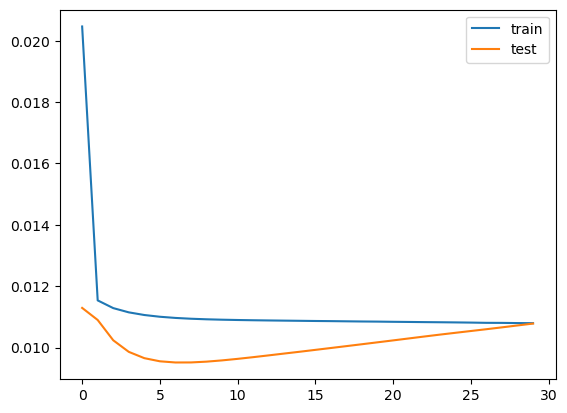

In [38]:
# design network with 100 neurons
model = Sequential()
model.add(LSTM(100, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')
# fit network
history = model.fit(x_train, y_train, epochs=30, batch_size=1, validation_data=(x_test, y_test), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

Now that our model is trained, lets test it on our test set and evaluate the model

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Test RMSE: 0.0016340784493244966


/var/folders/mq/2hlc7t3j1n70sc6bwnvg849r0000gn/T/ipykernel_94523/2263781401.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['Predicted CPI'] = inv_yhat


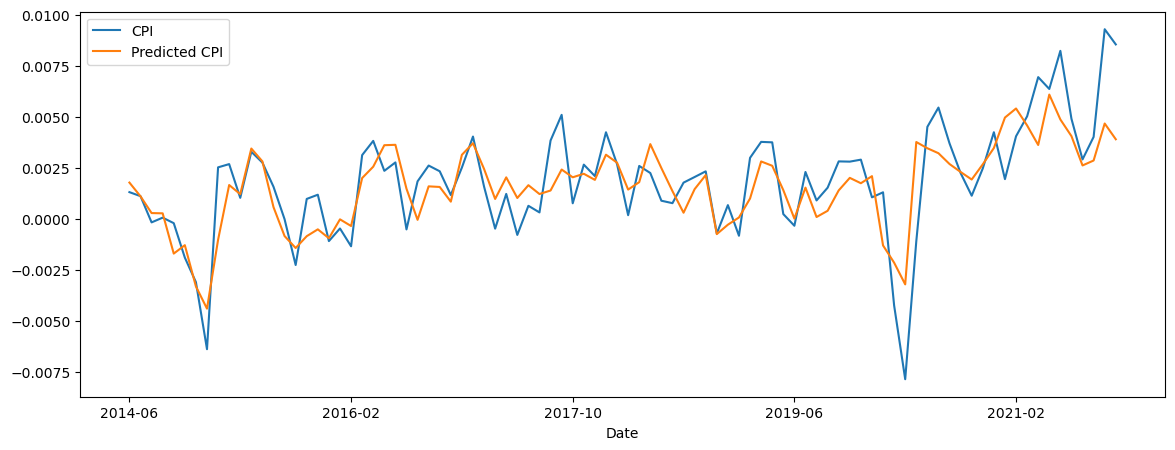

In [40]:
# make a prediction
yhat = model.predict(x_test)
# invert scaling for our forcast
inv_yhat = y_scaler.inverse_transform(yhat)
# Add our forecast to the test dataframe and plot the results
df_test['Predicted CPI'] = inv_yhat
df_test[['CPI','Predicted CPI']].plot(figsize=(14,5))
# Calculate RMSE
multi_rmse=sqrt(mean_squared_error(df_test['CPI'],df_test['Predicted CPI']))
print('Test RMSE:' , multi_rmse)

In [42]:
df_test

,CPI,Oil,PPI,Unemployment,LaggedCPI,Predicted CPI
Date,,,,,,
2014-06,0.001321,0.035330,0.001442,0.032787,0.001903,0.001790
2014-07,0.001125,-0.020796,-0.001440,0.031746,0.001321,0.001116
2014-08,-0.000160,-0.068057,-0.004808,-0.030769,0.001125,0.000297
2014-09,0.000072,-0.034493,-0.002899,-0.095238,-0.000160,0.000283
2014-10,-0.000198,-0.094518,-0.014535,-0.035088,0.000072,-0.001688
...,...,...,...,...,...,...
2021-07,0.004914,0.015551,0.012888,-0.065574,0.008240,0.004064
2021-08,0.002923,-0.065664,0.006750,-0.070175,0.004914,0.002628
2021-09,0.004025,0.057877,0.009695,-0.132075,0.002923,0.002870


### Discussion

#### Root Mean Squared Error Immediate Insights

Root Mean Square Error (RMSE) is the standard deviation of the residuals (prediction errors). Residuals are a measure of how far from the actual CPI change data the forecasted values are and RMSE is a measure of how spread out these residuals are. RMSE is an easy general metric we can use to evaluate our LSTM models on the accuracy of their predictions. 

The resulting RMSEs are:

In [44]:
print('Univariate Long Short Memory Network RMSE:' , uni_rmse)
print('Multivariate Long Short Memory Network RMSE:' , multi_rmse)

Univariate Long Short Memory Network RMSE: 0.002361979406184123
Multivariate Long Short Memory Network RMSE: 0.0016340784493244966


Looking at RMSE scores, it appears that the Univariate LSTM model is more accurate than the Multivariate LSTM model at predicing monthly CPI change. 

However, taking a look at the graph for Predicted vs Actual values for the multivariate LSTM model shows a giant temporary divergence between predicted and actual values around the start of 2020. Without this anomaly, it appears that the multivariate model manages to predict CPI change pretty well and would probably have a much close RMSE score to the univariate model if we removed this anomalous period from the testing phase.

This anomaly could have been cause by the start of the Covid-19 pandemic which coincides with the time period that this anomaly happens. Since the multivariate LSTM model takes into account other independent predictors, namely oil prices, producer price index (PPI) and unemployment rates, it is possible that one or several of these variables was severely impacted by the onset of the pandemic, resulting in a corresponding huge spike in predicted CPI change by our model which did not materialise in the real world. 

Such an event captured in our out of sample data is hard to model as this pandemic is extremely out of the norm and would be hard to train for. Should such similar models be used in the future for prediction of CPI, it would be advisable for the user to keep in mind their current world order and to take note of any extremities that could cause erroneously large mispredictions like the one we have witnessed here.

#### Improvements and future developments using LSTM to predict CPI
While we managed to create two seemingly capable LSTM models here to predict CPI, there is still a lot that can be explored to optimise these models and create improved models. Some future developments that could be explored are:

##### Trying other variables
We only managed to train our LSTM models using predictors such as oil price and unemployment data. It would be interesting to see how LSTM models trained with the other factors such as s&p500 could perform and if they might even have an outperformance as opposed to the comparative performance we have seen in our K-Nearest Neighbours, ARIMA, and Linear Regression models.

##### Training and testing on different time periods
The two models trained were only trained using sequentially older data and tested on the most recent years. Looking at how tumultous the past two years have been for inflation and CPI due to Covid-19, it would be beneficial to see how a model trained on the most recent years would perform. It would also be insightful to see how this subsequent model would perform on out of sample data from another period such as the 1990s.

##### Hyperparamter turning
Like any other maching learning mode, LSTMs and RNNs have a lot of hyperparameters that can be further tuned to optimise the models. Some examples of parameters that we can tune are number of epochs when traning, number of dense layers, if we want to include any additional layers, number of neurons in our model,and much more.

##### Modelling with limitations in mind
As this is time series data, it would be insightful to explore features of our dataset such as seasonality and staionarity. For example if our data was seasonal, the LSTM model could be modeled in a way that would try to predict the cyclic nature of CPI (if it exists).